In [2]:
import numpy as np
import sys
import pandas as pd
from scipy import optimize
sys.path.append("../")
sys.path.append("../processing")
sys.path.append("../mappings")
from run_processing import convert_top_level_dir_to_dataframe, load_measurement
from tune_waveform_modeling import get_channel_data

In [3]:
input_dir = "../scanData/raw/APA_5947a8b0-5152-11ed-84c6-9170f34dd09b_apa4_dwa5/"
raw_df = convert_top_level_dir_to_dataframe(input_dir)
raw_df

,datetime,layer,side,headboard_num,json_path,scan_id
0,2023-02-08 14:35:07,U,B,7,../scanData/raw/APA_5947a8b0-5152-11ed-84c6-91...,20230208T143507_U_B_7_138-140-142-144-146-148-...
1,2023-02-08 18:31:04,U,A,8,../scanData/raw/APA_5947a8b0-5152-11ed-84c6-91...,20230208T183104_U_A_8_97-99-101-103-105-107-10...
2,2023-02-08 15:32:55,X,B,4,../scanData/raw/APA_5947a8b0-5152-11ed-84c6-91...,20230208T153255_X_B_4_145-147-149-151-153-155-...
3,2023-02-08 17:27:37,U,A,3,../scanData/raw/APA_5947a8b0-5152-11ed-84c6-91...,20230208T172737_U_A_3_298-300-302-304-306-308-...
4,2023-02-08 13:27:01,X,B,9,../scanData/raw/APA_5947a8b0-5152-11ed-84c6-91...,20230208T132701_X_B_9_418-420-422-424-426-428-...
...,...,...,...,...,...,...
283,2023-02-08 13:26:26,X,B,9,../scanData/raw/APA_5947a8b0-5152-11ed-84c6-91...,20230208T132626_X_B_9_402-404-406-408-410-412-...
284,2023-02-08 15:33:12,X,B,4,../scanData/raw/APA_5947a8b0-5152-11ed-84c6-91...,20230208T153312_X_B_4_146-148-150-152-154-156-...
285,2023-02-08 17:36:24,U,A,4,../scanData/raw/APA_5947a8b0-5152-11ed-84c6-91...,20230208T173624_U_A_4_242-244-246-248-250-252-...
286,2023-02-08 14:06:42,X,B,8,../scanData/raw/APA_5947a8b0-5152-11ed-84c6-91...,20230208T140642_X_B_8_369-371-373-375-377-379-...


In [46]:
dwa_channel = 0
scan_dict = load_measurement(raw_df, raw_df.loc[42, "scan_id"])

layer = scan_dict["layer"]
apa_channel = scan_dict["apa_channels"][dwa_channel]
channel_dict = scan_dict[apa_channel]

<Axes: xlabel='Frequency (Hz)', ylabel='Amplitude'>

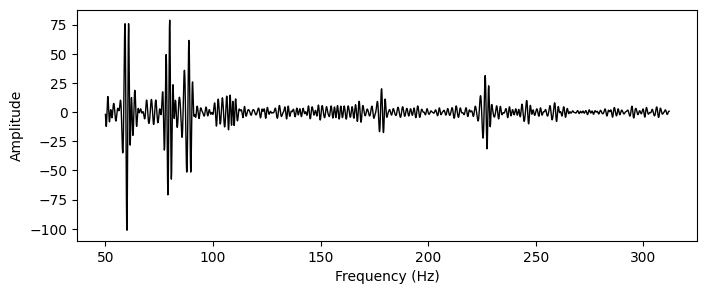

In [47]:
from importlib import reload
import plotting

reload(plotting)

plotting.plot_channel(channel_dict, figsize=(8, 3), color="k", lw=1, show_expectation=False)

<Axes: xlabel='Frequency (Hz)', ylabel='Width'>

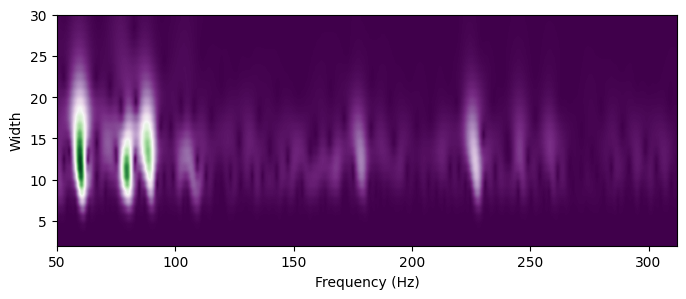

In [52]:
reload(plotting)
plotting.plot_channel_cwt_matr(channel_dict, widths=(2, 30), figsize=(8, 3))

<Axes: xlabel='Frequency (Hz)', ylabel='Amplitude'>

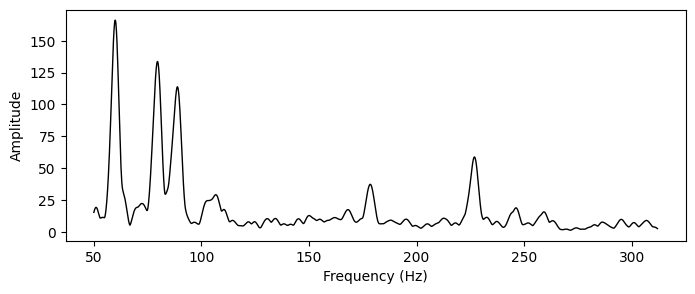

In [49]:
reload(plotting)
plotting.plot_channel_cwt(channel_dict,  scan_dict["layer"], widths=(8, 16), side=scan_dict["side"], figsize=(8, 3), color="k", lw=1)